In [13]:
from boot_utes import (reload, add_path, path, run_magics)
add_path('..', '../src/', '~/repos/myutils/', )

from src.crash_imps import *; exec(pu.DFCols_str); exec(pu.qexpr_str); run_magics()
# import utils.en_utils as eu; import data.load_data as ld; exec(eu.sort_dfs_str)

sns.set_style('whitegrid')


# A.data_transformers.enable('json', prefix='../data/altair-data')
A.data_transformers.enable('default')

S = Series; D = DataFrame

from big_query import bq_read

import warnings
from matplotlib import MatplotlibDeprecationWarning

from joblib import Memory

mem = Memory(location="cache", verbose=0)

import altair.vegalite.v3 as A
import requests
pd.options.display.max_rows = 100
pd.options.display.min_rows = 40

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load

In [5]:
import covid_scrape as cvs
from covid_scrape import lgs, pl
import model_transformations as mtx

data_dir = Path('../data')
load_states = mem.cache(cvs.load_states)

In [11]:
cvs.pull_and_save_ga_county()
cvs.pull_and_save_ga_agg()
dfct = cvs.load_ga_county()
ga_agg = cvs.load_ga_agg()

written today
File for 2020-03-22 already exists!


In [10]:
dfs = (
    load_states(date="03-20")
    .sort_values(["state", "date"], ascending=True)
    .reset_index(drop=1)
)
print(f"Max date {dfs.date.max()}")
dfs = cvs.process_state(dfs)
print(f"Current actual max date: {cvs.load_states().date.max()}")

Max date 20200322
Current actual max date: 20200322


# Models

## Mortality model

In [14]:
def write_model(mbase, dfsim, form, plot):
    """
    Save formula, plots, vegalite spec, predicted data to `mbase`
    model dir.
    """
    dfsim.to_parquet(mbase / 'preds.pq')
    with open(mbase / 'form.txt', 'w') as fp:
        fp.write(f"Formula: {form}")
        
    with A.data_transformers.enable('default'):
        A.Chart.save(plot, str(mbase / 'preds.png'))
        A.Chart.save(plot, str(mbase / 'preds.json'))

In [28]:
# import pystan

def log_preds(df):
    preds = [c for c in df if c.startswith('pred_')]
    df = df.assign(**{pred: lambda x, pred=pred: 10 ** x[pred] for pred in preds})
    return df

dfd = cvs.filter_mortality(dfs)

dfd = (
    dfd.assign(
        ldeaths=lambda x: x.death.pipe(np.log10),
        daysi=lambda x: (x.date - x.date.min()).astype('timedelta64[D]').astype(int)
    )
    .reset_index(drop=1)
    .drop(["dateChecked", 'pending'], axis=1)
)

[min_date] = dfd.query("daysi == 0").date

def dayi2date(i):
    return min_date + pd.Timedelta(days=i)

dfsim1_ = mtx.mk_sim_df1(dfd).assign(date=lambda x: x.daysi.map(dayi2date))

# Write to R; generate simulations
dfd.to_feather(data_dir / 'mort_0320.fth')
dfsim1_.to_feather(data_dir / 'mort_0320_sim.fth')

## Model v1

In [31]:
# Read end result
dfsim_out = pd.read_feather('covid/data/mort_0320_sim_out.fth')
dfsim1 = dfsim1_.merge(dfsim_out, on='row').pipe(log_preds)

#### Plot Results

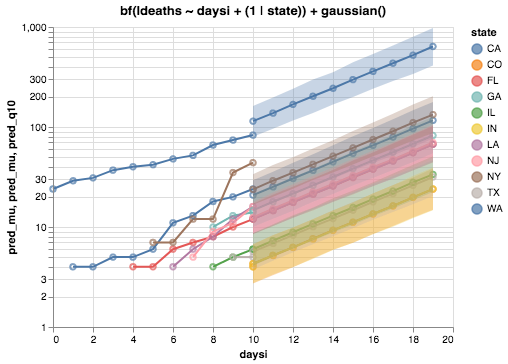

In [45]:
color = "state"
x = "daysi"
y = "pred_mu"


pred = dfsim1
actual = dfd.assign(pred_mu=lambda x: x["death"])


def deco(ch):
    h = ch.mark_line().encode(
        x=A.X(x, title=x),
        y=A.Y(y, title=y, scale=lgs),
        color=color,
        tooltip=[color, x, y],
    )
    return h


h_act = deco(Chart(actual))
h_est = deco(Chart(pred))
h_est_err = h_est.mark_errorband().encode(
    y="pred_q10", y2="pred_q90", x="daysi", color=color,
)

ch_act = h_act + h_act.mark_point()
ch_est = h_est + h_est.mark_point() + h_est_err


form1 = "bf(ldeaths ~ daysi + (1 | state)) + gaussian()"
save_ch = (ch_act + ch_est).properties(title=form1)
save_ch

In [51]:
# m1_path = Path('covid/models/mortal/v1')
# write_model(m1_path, dfsim1, "bf(ldeaths ~ daysi + (1 | state)) + gaussian()", save_ch)

## Model v2

In [44]:
dfsim_out = pd.read_feather(data_dir / 'mort_v2_sim_out.fth')
dfsim2 = dfsim1_.merge(dfsim_out, on='row').pipe(log_preds).assign(date=lambda x: x.daysi.map(dayi2date))

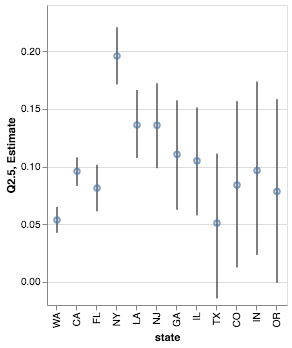

In [43]:
color = 'dvers'
x = 'state'
y = 'Estimate'

m2_coefs = (
    pd.read_feather(data_dir / "mort_m2_coef.fth")
    .sort_values("Est.Error", ascending=True)
    .reset_index(drop=1)
)

pdf = m2_coefs

h = Chart(pdf).mark_point().encode(
    x=A.X(x, title=x, sort=None),
    y=A.Y(y, title=y),
    tooltip=[x, y]
)

herr = h.mark_errorbar().encode(y='Q2.5', y2='Q97.5')
# (h + h.mark_point()).interactive()
herr + h

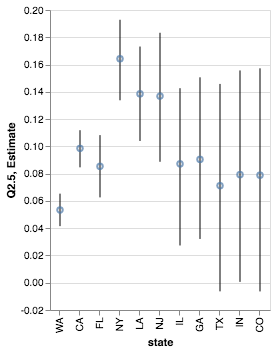

In [50]:
def plot_preds_act(dfsim, dfd, form, x = "daysi", log=True):
    color = "state"
    yargs = {}
    if log:
        yargs['scale'] = lgs
    y = "pred_mu"

    pred = dfsim
    actual = dfd.assign(pred_mu=lambda x: x["death"])

    def deco(ch):
        h = ch.mark_line().encode(
            x=A.X(x, title=x),
            y=A.Y(y, title=y, **yargs),
            color=color,
            tooltip=[color, x, y],
        )
        return h

    h_act = deco(Chart(actual))
    h_est = deco(Chart(pred))
    h_est_err = h_est.mark_errorband().encode(
        y="pred_q10", y2="pred_q90", x=x, color=color
    )

    ch_act = h_act + h_act.mark_point()
    ch_est = h_est + h_est.mark_point() + h_est_err

    save_ch = (ch_act + ch_est).properties(title=form)
    return save_ch


# bf(ldeaths ~ (1 | state) + daysi + (0 + daysi | state))
form2 = "ldeaths ~ (1 | state) + daysi + (0 + daysi | state)"

m2pl_lin = plot_preds_act(dfsim=dfsim2, dfd=dfd, form=form2, x='date', log=0).properties(width=900, height=600)
m2pl_log = plot_preds_act(dfsim=dfsim2, dfd=dfd, form=form2, x='date', log=1).properties(width=900, height=600)

with A.data_transformers.enable('default'):
    A.Chart.save(m2pl_lin, '../fig/m2_pred_lin_0322.png')

with A.data_transformers.enable('default'):
    A.Chart.save(m2pl_log, '../fig/m2_pred_log_0322.png')

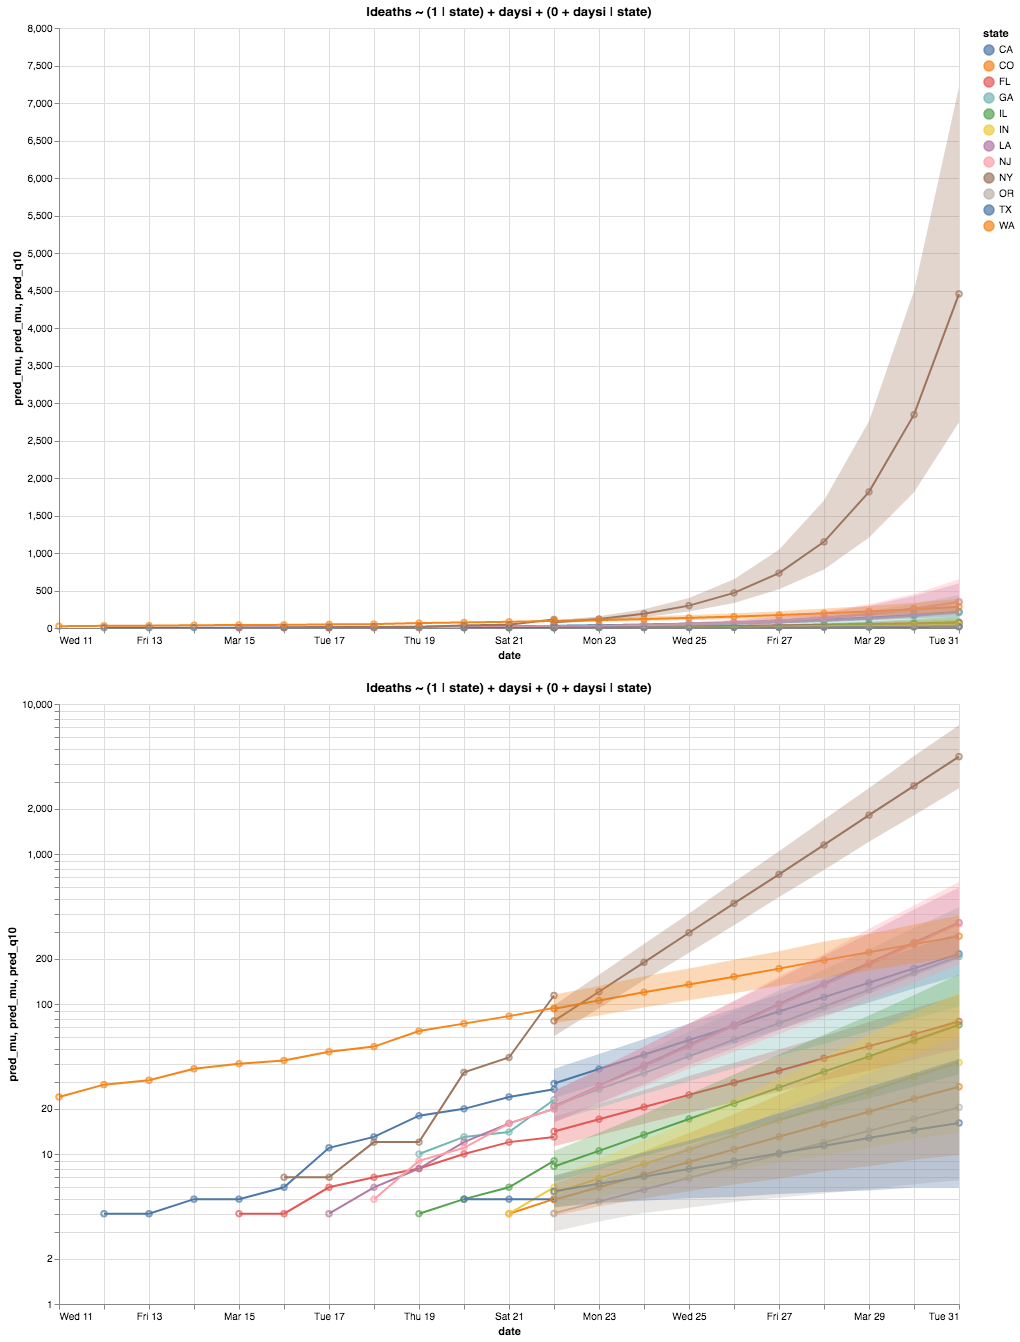

In [52]:
m2pl_lin & m2pl_log

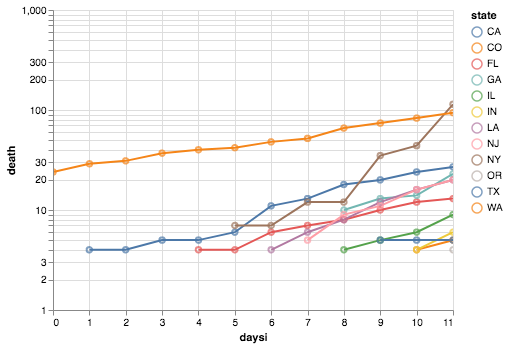

In [49]:
p2 = pl(dfd, x='daysi', y='death')
p2

In [113]:
dfs[:3]

,date,state,positive,negative,pending,death,total,dateChecked,perc,dupe_neg,n_pct_rows
0,2020-03-06,AK,0,8.0,1.0,NaN,9,2020-03-06T21:00:00Z,0.0,False,1
1,2020-03-07,AK,0,12.0,2.0,NaN,14,2020-03-07T21:00:00Z,0.0,False,1
2,2020-03-08,AK,0,14.0,6.0,NaN,20,2020-03-08T20:00:00Z,0.0,False,1


In [114]:
pdf = dfs.query("positive > 0").query("n_pct_rows > 3")

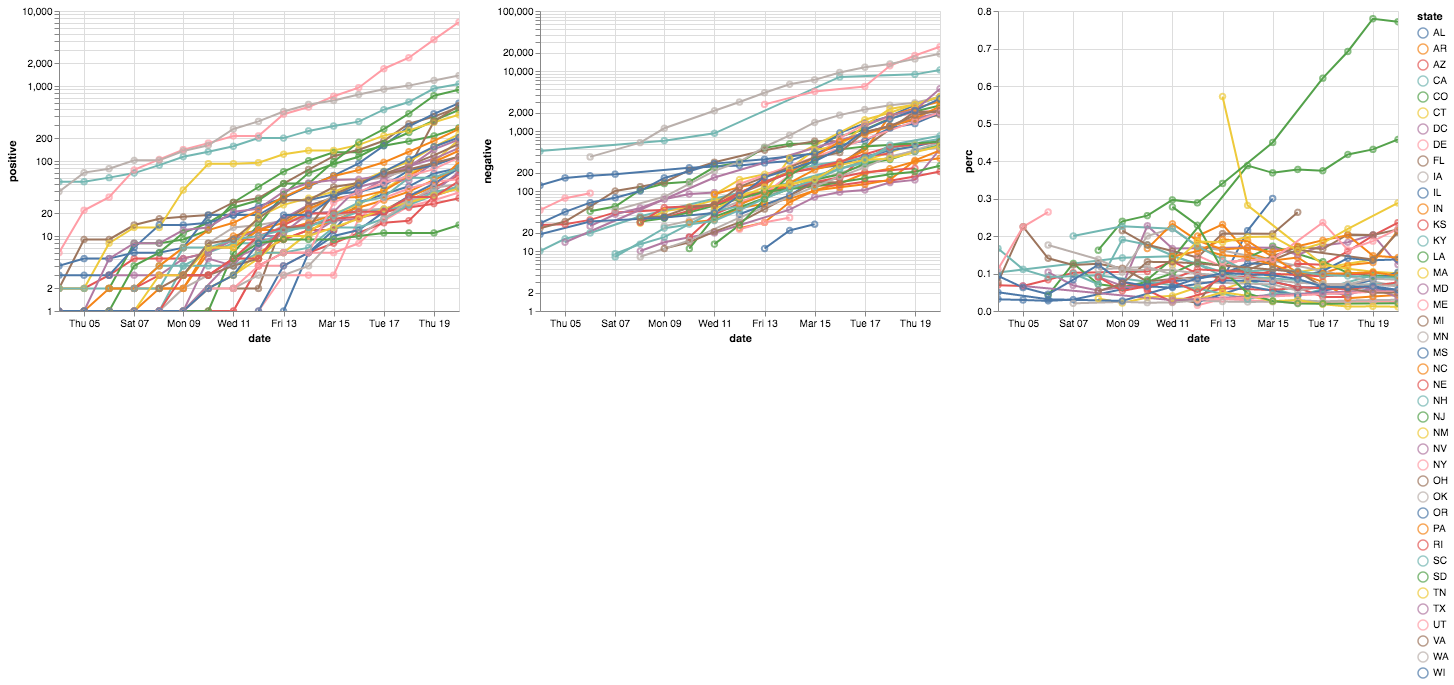

In [115]:
pl(pdf, color="state") | pl(pdf.query("~dupe_neg"), y="negative") |  pl(pdf.query("~dupe_neg"), y="perc", logy=0)